<a href="https://colab.research.google.com/github/MartRideratGamaGama/SimCLR-Deep-Learning-Final-Project-/blob/main/MartSimclr_Labeled_(Latest).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi-supervised image classification using contrastive pretraining with SimCLR

**Author:** [András Béres](https://www.linkedin.com/in/andras-beres-789190210)<br>
**Date created:** 2021/04/24<br>
**Last modified:** 2021/04/24<br>
**Description:** Contrastive pretraining with SimCLR for semi-supervised image classification on the STL-10 dataset.

## Introduction

### Semi-supervised learning

Semi-supervised learning is a machine learning paradigm that deals with
**partially labeled datasets**. When applying deep learning in the real world,
one usually has to gather a large dataset to make it work well. However, while
the cost of labeling scales linearly with the dataset size (labeling each
example takes a constant time), model performance only scales
[sublinearly](https://arxiv.org/abs/2001.08361) with it. This means that
labeling more and more samples becomes less and less cost-efficient, while
gathering unlabeled data is generally cheap, as it is usually readily available
in large quantities.

Semi-supervised learning offers to solve this problem by only requiring a
partially labeled dataset, and by being label-efficient by utilizing the
unlabeled examples for learning as well.

In this example, we will pretrain an encoder with contrastive learning on the
[STL-10](https://ai.stanford.edu/~acoates/stl10/) semi-supervised dataset using
no labels at all, and then fine-tune it using only its labeled subset.

### Contrastive learning

On the highest level, the main idea behind contrastive learning is to **learn
representations that are invariant to image augmentations** in a self-supervised
manner. One problem with this objective is that it has a trivial degenerate
solution: the case where the representations are constant, and do not depend at all on the
input images.

Contrastive learning avoids this trap by modifying the objective in the
following way: it pulls representations of augmented versions/views of the same
image closer to each other (contracting positives), while simultaneously pushing
different images away from each other (contrasting negatives) in representation
space.

One such contrastive approach is [SimCLR](https://arxiv.org/abs/2002.05709),
which essentially identifies the core components needed to optimize this
objective, and can achieve high performance by scaling this simple approach.

Another approach is [SimSiam](https://arxiv.org/abs/2011.10566)
([Keras example](https://keras.io/examples/vision/simsiam/)),
whose main difference from
SimCLR is that the former does not use any negatives in its loss. Therefore, it does not
explicitly prevent the trivial solution, and, instead, avoids it implicitly by
architecture design (asymmetric encoding paths using a predictor network and
batch normalization (BatchNorm) are applied in the final layers).

For further reading about SimCLR, check out
[the official Google AI blog post](https://ai.googleblog.com/2020/04/advancing-self-supervised-and-semi.html),
and for an overview of self-supervised learning across both vision and language
check out
[this blog post](https://ai.facebook.com/blog/self-supervised-learning-the-dark-matter-of-intelligence/).

## Setup

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-c901099c-408b-bec2-a6ab-b91cbc417e6a)


In [ ]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import tensorflow_addons as tfa

import glob
import cv2 as cv

## Hyperparameter setup

In [ ]:
# Dataset hyperparameters
unlabeled_dataset_size = 100000
labeled_dataset_size = 5000
image_size = 96
image_channels = 3

# Algorithm hyperparameters
num_epochs = 100


#batch_size = 525
batch_size =16  
width = 128
temperature = 0.1
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

#np.random.seed(1234)
#tf.random.set_seed(5678) #ถ้าได้ผลที่พอใจแล้วค่อยเอา seed ออก แล้ว

## Dataset

During training we will simultaneously load a large batch of unlabeled images along with a
smaller batch of labeled images.

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_train = "/content/drive/MyDrive/Final project/dataset/Plant Diseases_Organized/train"
#path_valid = "/content/drive/MyDrive/Final project/dataset/Plant Diseases_Organized/valid" #ข้อมูลเยอะเกินรันไม่ไหว
path_test = "/content/drive/MyDrive/Final project/dataset/Plant Diseases_Organized/test"
path_labeled = "/content/drive/MyDrive/Final project/dataset/Plant Diseases_Organized/labeled"#แยกข้อมูลออกมาแล้ว (ใช่จริง)

#path_labeled = "/content/drive/MyDrive/Final project/dataset/Plant Diseases_Organized/labeled2"#ไว้ลอง code

labels = inferred (labels are generated from the directory structure), None (no labels)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_labeled, labels = 'inferred', 
                                                               label_mode ="int",image_size = (image_size,image_size),
                                                               ) #แบบนี้จะได้ label ติดมาด้วย

Found 3150 files belonging to 21 classes.


In [ ]:
train_ds
#<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
#train_ds_unlabels = tf.keras.preprocessing.image_dataset_from_directory(path, label_mode = None, image_size = (image_size,image_size)) #แบบนี้ถึงจะได้แบบ ไม่มี label
train_ds_unlabels = tf.keras.preprocessing.image_dataset_from_directory(path_train, label_mode = "int", image_size = (image_size,image_size)) #แบบนี้ถึงจะได้แบบ มี label

Found 69934 files belonging to 21 classes.


In [ ]:
train_ds_unlabels
#<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


<BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(path_test, label_mode = "int", image_size = (image_size,image_size))

Found 380 files belonging to 21 classes.


In [ ]:
train_1 = tf.data.Dataset.zip((train_ds_unlabels, train_ds)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
test_1 = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_1

#<PrefetchDataset element_spec=((TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None))>
#<PrefetchDataset element_spec=((TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), (TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None)))>


<PrefetchDataset element_spec=((TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)))>

In [ ]:
test_1

#<PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


<PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


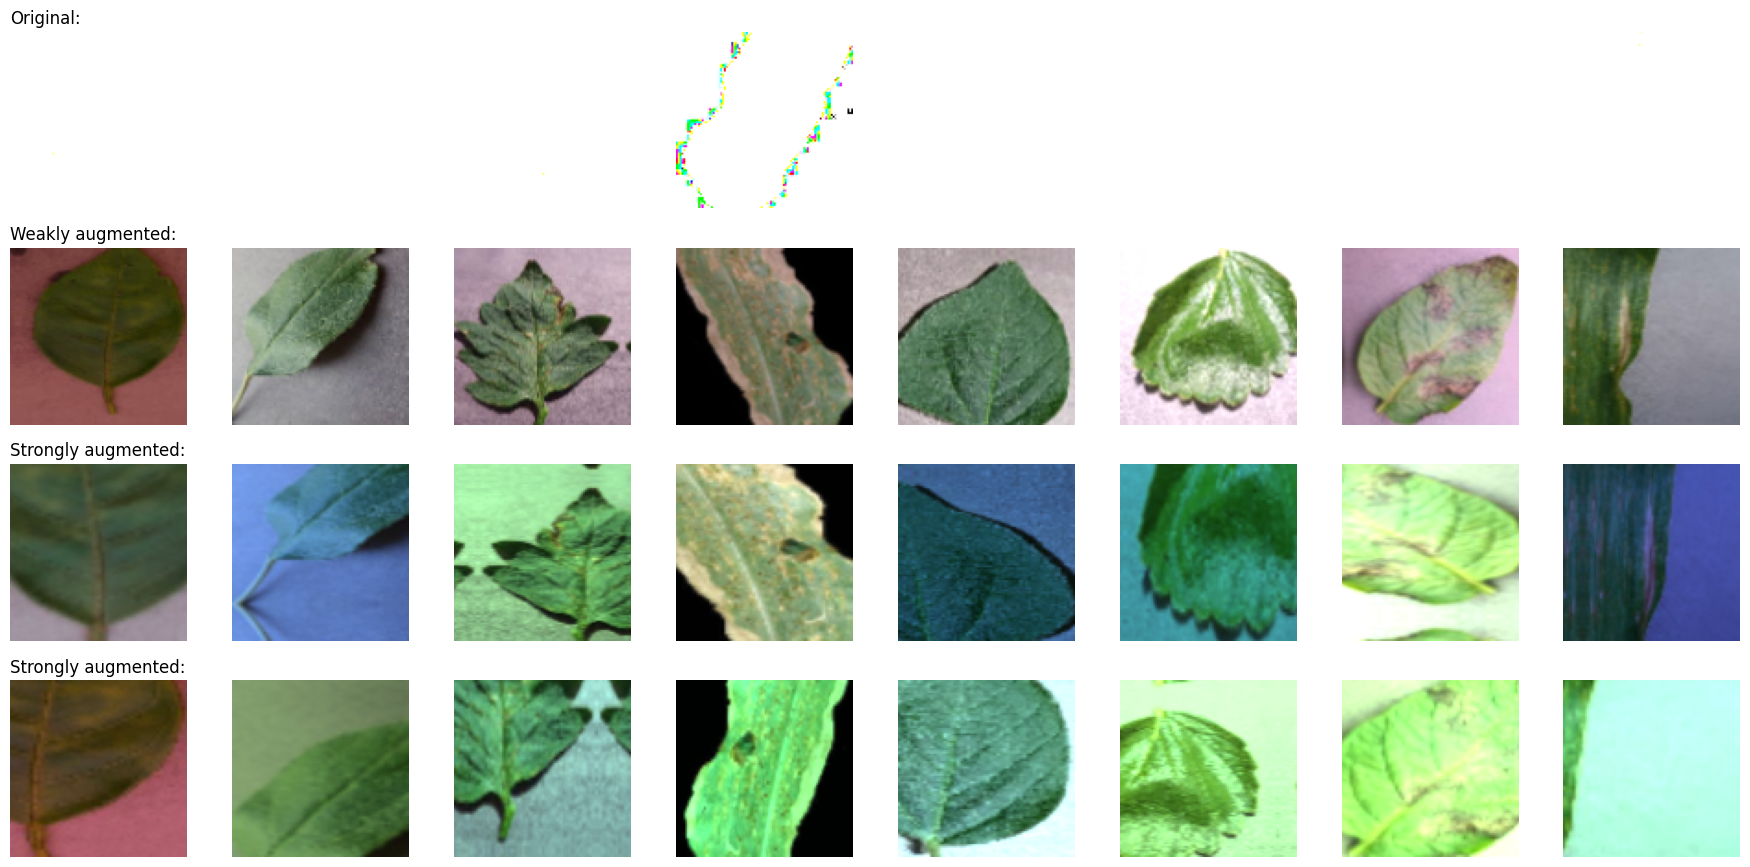

In [ ]:

# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images


# Image augmentation module
def get_augmenter(min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )


def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_1))[0][0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
        get_augmenter(**contrastive_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Weakly augmented:",
        "Strongly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

## Encoder architecture

In [ ]:
resnet50 = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights='imagenet',
        input_shape=(image_size, image_size, image_channels),
)
resnet50.trainable = False
resnet50.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 102, 102, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 48, 48, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 50, 50, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [ ]:
# Define the encoder architecture with imported architecture

def get_encoder():
    return keras.Sequential(
        [   resnet50,
            layers.Flatten(),
            layers.Dense(width, activation="relu"),
        ],
        name="encoder",
    )





## Supervised baseline model

A baseline supervised model is trained using random initialization.

In [ ]:
# Baseline supervised training with random initialization
checkpoint_baseline = ModelCheckpoint(filepath="best_weights_baseline.hdf5",  monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint_baseline]

baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        get_encoder(),
        layers.Dense(21),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

baseline_history = baseline_model.fit(
    train_ds, epochs=num_epochs, callbacks=[callbacks_list],validation_data=test_ds
)

print(
    "Maximal training accuracy: {:.2f}%".format(
        max(baseline_history.history["acc"]) * 100
    )
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

print(
    "Minimaum training loss: {:.2f}".format(
        min(baseline_history.history["loss"])
    )
)

print(
    "Minimaum validation loss: {:.2f}".format(
        min(baseline_history.history["val_loss"])
    )
)

Epoch 1/100
99/99 [==============================] - ETA: 0s - loss: 1.9397 - acc: 0.4917
Epoch 1: val_acc improved from -inf to 0.52632, saving model to best_weights_baseline.hdf5
99/99 [==============================] - 10s 53ms/step - loss: 1.9397 - acc: 0.4917 - val_loss: 1.7591 - val_acc: 0.5263
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 1.0210 - acc: 0.6898
Epoch 2: val_acc did not improve from 0.52632
99/99 [==============================] - 4s 40ms/step - loss: 1.0210 - acc: 0.6898 - val_loss: 2.0597 - val_acc: 0.5158
Epoch 3/100
99/99 [==============================] - ETA: 0s - loss: 0.7996 - acc: 0.7467
Epoch 3: val_acc improved from 0.52632 to 0.54474, saving model to best_weights_baseline.hdf5
99/99 [==============================] - 6s 54ms/step - loss: 0.7996 - acc: 0.7467 - val_loss: 2.1844 - val_acc: 0.5447
Epoch 4/100
97/99 [============================>.] - ETA: 0s - loss: 0.6911 - acc: 0.7835
Epoch 4: val_acc improved from 0.54474 to 0.5552

## Self-supervised model for contrastive pretraining

In [ ]:
#อาจจะเอา Backbone มาแทนพวก Encoder ได้
# Define the contrastive model with model-subclassing

#checkpoint_contrastive = ModelCheckpoint(filepath="best_weights_contrastive.hdf5",  monitor='val_p_acc', verbose=1, save_best_only=True, mode='auto')
#callbacks_list = [checkpoint_contrastive]
#ติด Error
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter(**contrastive_augmentation)
        self.classification_augmenter = get_augmenter(**classification_augmentation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(21)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        (unlabeled_images, _), (labeled_images, labels) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images, labeled_images), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(images, training=True)
        augmented_images_2 = self.contrastive_augmenter(images, training=True)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=True
        )
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = self.classification_augmenter(
            labeled_images, training=False
        )
        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(
    train_1, epochs=num_epochs, validation_data=test_ds
)
print(
    "Maximal training accuracy: {:.2f}%".format(
        max(pretraining_history.history["p_acc"]) * 100
    )
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

print(
    "Minimum training loss: {:.2f}".format(
        min(pretraining_history.history["p_loss"])
    )
)
print(
    "Minimum validation loss: {:.2f}".format(
        min(pretraining_history.history["val_p_loss"])
    )
)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2359424   
                                                                 
Total params: 25,924,224
Trainable params: 2,359,424
Non-trainable params: 23,564,800
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dens

## Supervised finetuning of the pretrained encoder

We then finetune the encoder on the labeled examples, by attaching
a single randomly initalized fully connected classification layer on its top.

## Comparison against the baseline

In [ ]:
# Supervised finetuning of the pretrained encoder

checkpoint_finetuning = ModelCheckpoint(filepath="best_weights_finetuning.hdf5",  monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint_finetuning]

finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        pretraining_model.encoder,
        layers.Dense(21),
    ],
    name="finetuning_model",
)
finetuning_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

finetuning_history = finetuning_model.fit(
    train_ds, epochs=num_epochs, callbacks=[callbacks_list],validation_data=test_ds
)

print(
    "Maximal training accuracy: {:.2f}%".format(
        max(finetuning_history.history["acc"]) * 100
    )
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_acc"]) * 100
    )
)

print(
    "Minimum training loss: {:.2f}".format(
        min(finetuning_history.history["loss"])
    )
)

print(
    "Minimum validation loss: {:.2f}".format(
        min(finetuning_history.history["val_loss"])
    )
)

Epoch 1/100
99/99 [==============================] - ETA: 0s - loss: 19.7592 - acc: 0.3800
Epoch 1: val_acc improved from -inf to 0.45000, saving model to best_weights_finetuning.hdf5
99/99 [==============================] - 8s 50ms/step - loss: 19.7592 - acc: 0.3800 - val_loss: 14.8045 - val_acc: 0.4500
Epoch 2/100
99/99 [==============================] - ETA: 0s - loss: 5.3816 - acc: 0.6321
Epoch 2: val_acc improved from 0.45000 to 0.51053, saving model to best_weights_finetuning.hdf5
99/99 [==============================] - 5s 46ms/step - loss: 5.3816 - acc: 0.6321 - val_loss: 10.9373 - val_acc: 0.5105
Epoch 3/100
97/99 [============================>.] - ETA: 0s - loss: 3.3720 - acc: 0.7065
Epoch 3: val_acc improved from 0.51053 to 0.55000, saving model to best_weights_finetuning.hdf5
99/99 [==============================] - 5s 48ms/step - loss: 3.3613 - acc: 0.7083 - val_loss: 8.8021 - val_acc: 0.5500
Epoch 4/100
97/99 [============================>.] - ETA: 0s - loss: 2.5415 - acc

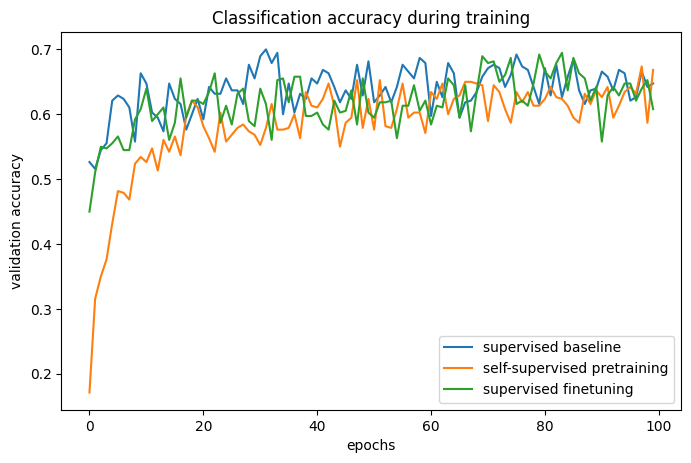

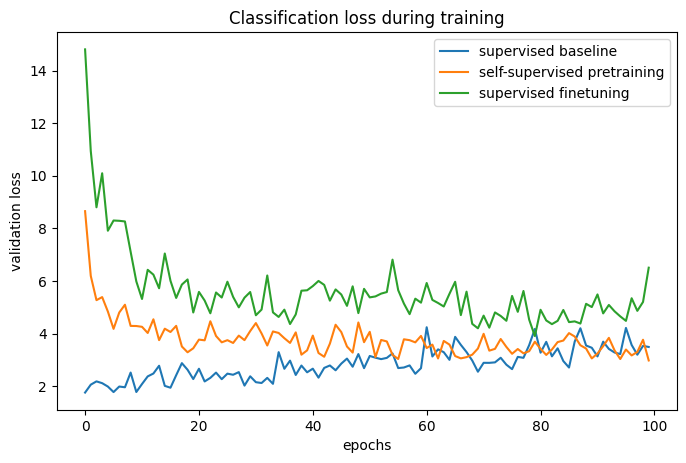

In [ ]:

# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_training_curves(pretraining_history, finetuning_history, baseline_history)

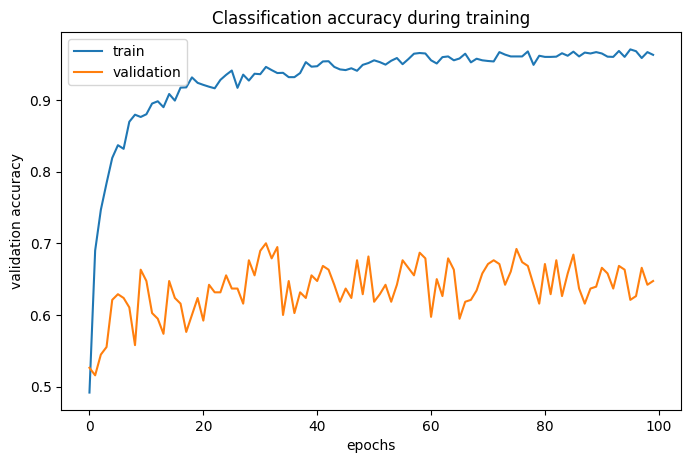

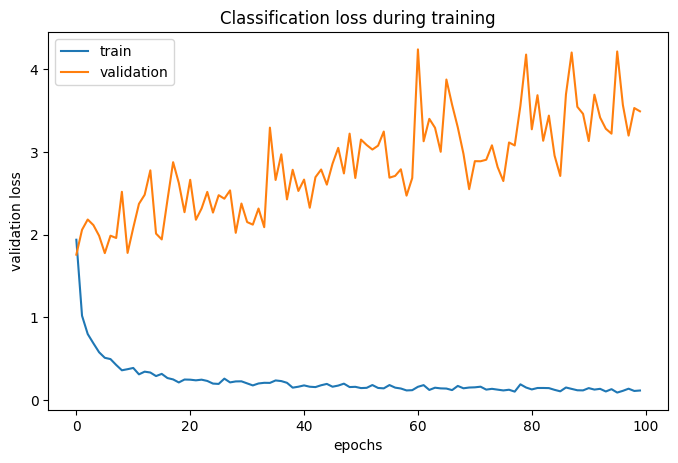

In [ ]:
#Plot basedline
def plot_basedline_curves(baseline_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"{metric_key}"], label="train"
        )
        plt.plot(
            baseline_history.history[f"val_{metric_key}"],
            label="validation"
        )

        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_basedline_curves(baseline_history)

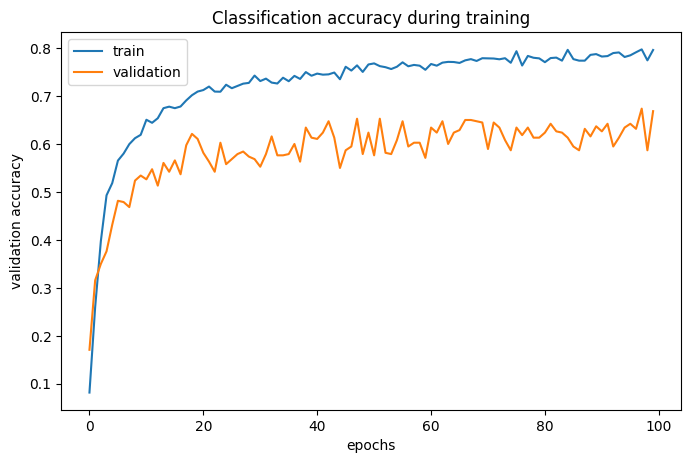

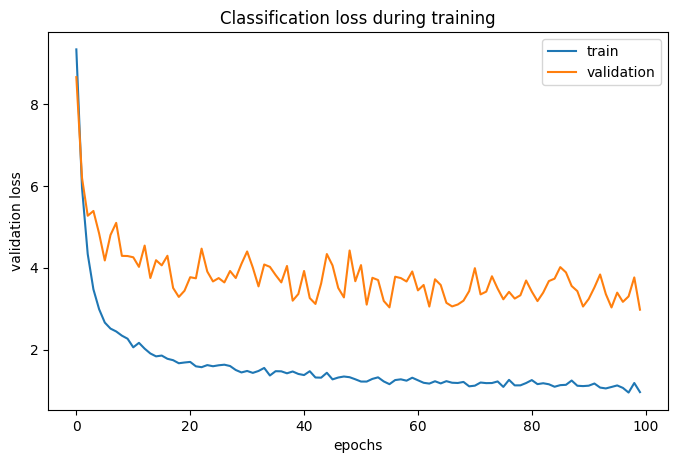

In [ ]:
#Plot contrastive
def plot_pretrained_curves(pretraining_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            pretraining_history.history[f"p_{metric_key}"], label="train"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="validation"
        )

        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_pretrained_curves(pretraining_history)

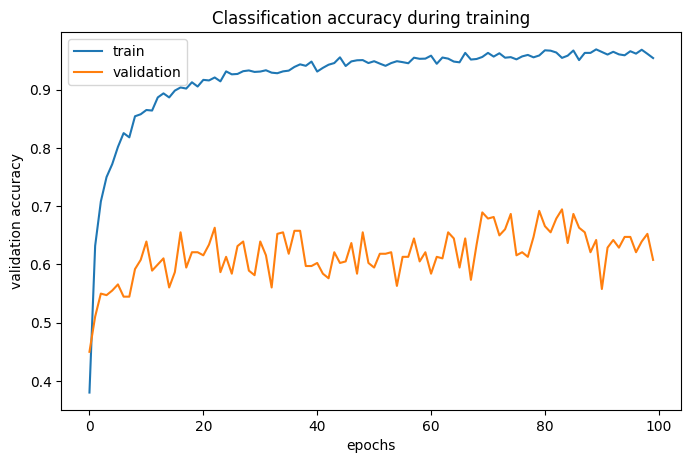

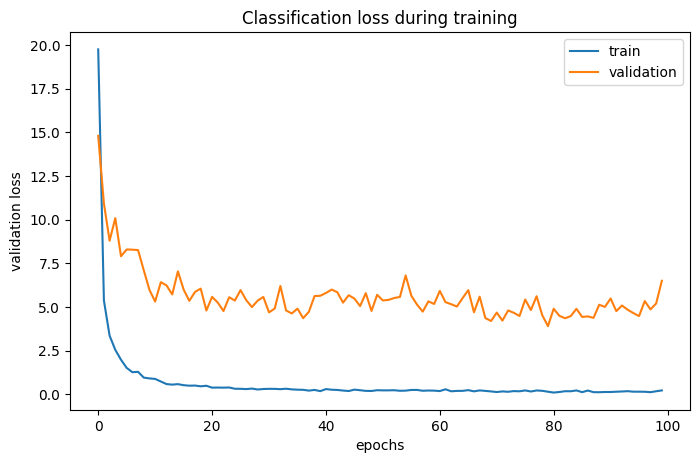

In [ ]:
#Plot finetuning
def plot_finetunung_curves(finetuning_history):
    for metric_key, metric_name in zip(["acc", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            finetuning_history.history[f"{metric_key}"], label="train"
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="validation"
        )

        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")


plot_finetunung_curves(finetuning_history)